# Q-learning with Frozen Lake from OpenAI Gym


![](frozenlake4x4.png)
![](frozenlake.png)

The goal of this game is to go from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H). However, the ice is slippery, so you won't always move in the direction you intend (stochastic actions).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random

OpenAI Gym is a library with many environments which can be used to experiment with RL algorithms. Very nice about OpenAI Gym is the well-defined interface between agent and environment, which makes it easy to switch agents or environments. Also other RL libraries use the OpenAI Gym interfaces resulting in a very user-friendly ecosystem. OpenAI Gym can be installed using `conda install gym -c conda-forge`

For this example we're using the Frozen Lake environment. [Here](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) is the documentation.

In [2]:
# create the environment
env = gym.make("FrozenLake-v1", is_slippery=False)

# number of actions that can be performed in this environment (4, namely up, down, left, right)
action_size = env.action_space.n
# number of different states that this environment can have (16, because the agent can be on one of the tiles)
state_size = env.observation_space.n

# in every of the 16 states, the agent can take one of the 4 possible actions. Hence we need a Q-table of size:
qtable = np.zeros((state_size, action_size))
print(qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [3]:
# hyperparameters
total_episodes = 15000
learning_rate = 0.8
max_steps = 99  # max steps per episode
gamma = 0.95  # discount rate

epsilon = 1.0  # exploration probability; let's start with maximum exploration 
max_epsilon = 1.0  # max exploration probability
min_epsilon = 0.01  # minimum exploration probability 
decay_rate = 0.005  # exponential decay rate for exploration probability

In [4]:
# returned array has length: len(data_set) + window_size - 1
def moving_average(data_set, window_size=10):
    # non-weighted average
    weights = np.ones(window_size) / window_size
    return np.convolve(data_set, weights, mode='valid')

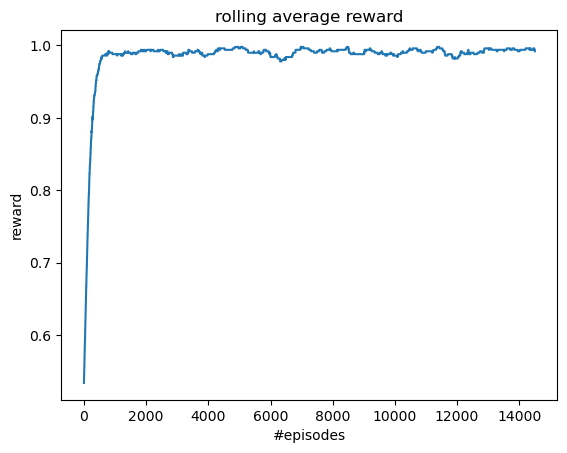

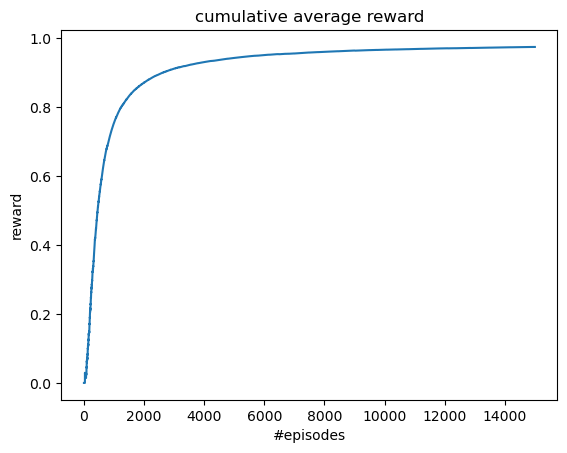

[[0.73509189 0.77378094 0.6983373  0.73509189]
 [0.73509189 0.         0.65650864 0.69799849]
 [0.69832894 0.42141696 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.77378094 0.81450625 0.         0.73509189]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.         0.65789072]
 [0.         0.         0.         0.        ]
 [0.81450625 0.         0.857375   0.77378094]
 [0.81450625 0.9025     0.9025     0.        ]
 [0.857375   0.95       0.         0.85737499]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.95       0.857375  ]
 [0.9025     0.95       1.         0.9025    ]
 [0.         0.         0.         0.        ]]


In [5]:
# list of cumulative reward per episode; every item is the cumulative reward of one episode
rewards = []

# "infinite" loop or until learning has stopped
for episode in range(total_episodes):
    print(f'episode {episode}', end='\r')
    
    # reset the environment
    state, info = env.reset()
    done = False
    cumulative_reward = 0
    
    for step in range(max_steps):
        # choose an action 'a' in the current world state (s)
        # - first randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        # - if this number > greater than epsilon -> exploitation (taking the biggest Q-value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
        # - else chose a random action (== exploration)
        else:
            action = env.action_space.sample()

        # take the action 'a' and observe the new state at t+1 and reward at t+1
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        #print(action, reward)

        # update rule Q(s,a) := Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state, :] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        cumulative_reward += reward
        
        # the new state becomes current state
        state = new_state
        
        # if done (== dead or reached goal), stop the episode
        if done: 
            break
        
    # reduce epsilon to slowly reduce the amount of exploration
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(cumulative_reward)

window_size = 500
plt.plot(range(total_episodes - window_size + 1), moving_average(rewards, window_size))
plt.title('rolling average reward')
plt.xlabel('#episodes')
plt.ylabel('reward')
plt.show()
cumsum = np.cumsum(rewards)
plt.plot(range(1, total_episodes), [cumsum[i]/i for i in range(1, total_episodes)])
plt.title('cumulative average reward')
plt.xlabel('#episodes')
plt.ylabel('reward')
plt.show()

# state 0: left-upper corner of lake
# state 1: one to the right
# state 2: one more to the right
# state 15: right-bottom corner of lake
# action 0, 1, 2, 3: LEFT, DOWN, RIGHT, UP 
print(qtable)

# Playing Frozen Lake using the trained Q-table
The movement direction of the agent is uncertain and only partially depends on the chosen direction


In [6]:
for episode in range(5):
    state, info = env.reset()
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        
        # take the action that has the maximum expected future reward, given the state (no exploration, just exploitation)
        action = np.argmax(qtable[state,:])
        
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        if done:
            # print the last state, to see if the agent reached the goal or fell into a hole
            env.render()
            print("number of steps taken to reach this result", step)
            break
        state = new_state
    if not done:
        print('{} steps were not enough to finish the episode'.format(max_steps))
env.close()

****************************************************
EPISODE  0
number of steps taken to reach this result 5
****************************************************
EPISODE  1
number of steps taken to reach this result 5
****************************************************
EPISODE  2
number of steps taken to reach this result 5
****************************************************
EPISODE  3
number of steps taken to reach this result 5
****************************************************
EPISODE  4
number of steps taken to reach this result 5


c:\Users\Justin\anaconda3\envs\snake_game\Lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py:328: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


## Discussion

You might notice that sometimes the algorithm takes very long to finish and the rolling and cumulative reward are 0. This is what happens: the environment only gives a positive reward when the walker reaches the goal. Only when this happens at least once, the algorithm is able to learn. There's some luck involved to get to the goal as in the beginning the q-table is empty and consequently doesn't give direction to the walker. On the other hand, the algorithm reduces the amount of exploration. This means that after some time the algorithm is almost only exploiting, meaning that it will never change its behavior and will not find the goal any more.

This is a problem that can also occur with other environments. A solution is to introduce multiple stages in learning. At first you help the agent to reach the endgoal at least once by providing intermediary rewards. Once the agent has reached the endgoal you remove the intermediary goals as they might result in a suboptimal solution.


[Based on](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb) 